# Rigol Waveform Creator
## Jan 2016
This is an updated interface to the DG4102 arb generator. It makes use of the usbtmc python library installed via `dnf install python3-usbtmc`. The basic interface is to create a handle to the instrument and then use `write`, `read`, or `ask` methods on the handle.

In [1]:
import numpy
import matplotlib.pyplot as plt
import usbtmc
%matplotlib inline

In [2]:
# this connects to the instrument directly using it's USB ID:
handle = usbtmc.Instrument(int("1AB1",16),int("0641",16))

In [55]:
# This will probably timeout the first time. Just run it again
handle.ask('*IDN?')

'Rigol Technologies,DG4102,DG4B151400125,00.01.04'

In [ ]:
# set voltage high
handle.write(":VOLT:HIGH 2.00")

In [4]:
handle.write(":SOUR1:APPL:USER 100,5,2.5,0")

In [5]:
handle.ask(":VOLTage:HIGH?")

'5.000000E+00'

In [6]:
handle.ask(":DATA:POINts? VOLATILE")

'40'

Now do some waveform creation:

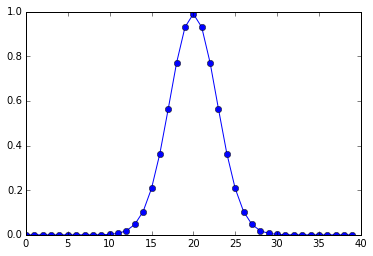

In [7]:
N = 40
x = numpy.array(range(40))
data = 0.99*numpy.exp(-((x-20)/4)**2)
plt.plot(data,"o-")

In [8]:
handle.write(":DATA:POINTS VOLATILE,{}".format(N))

In [9]:
handle.ask(":DATA:POINTS? VOLATILE")

'40'

In [29]:
datastring = str(list(data))
cleandatastring = datastring.lstrip("[").rstrip("]")
print(cleandatastring)

1.374906442631438e-11, 1.5734970993571205e-10, 1.5891757746337554e-09, 1.4164169499382011e-08, 1.1140982297206653e-07, 7.7333745142214458e-07, 4.7372662182077183e-06, 2.560941922042758e-05, 0.00012217570604581277, 0.00051437893533329011, 0.0019111495948654321, 0.0062664182732108898, 0.018132482499846836, 0.046302916160119389, 0.10434523231624569, 0.20751527327958683, 0.36420064675972791, 0.56408499648361377, 0.77101277524069078, 0.93001893218534104, 0.98999999999999999, 0.93001893218534104, 0.77101277524069078, 0.56408499648361377, 0.36420064675972791, 0.20751527327958683, 0.10434523231624569, 0.046302916160119389, 0.018132482499846836, 0.0062664182732108898, 0.0019111495948654321, 0.00051437893533329011, 0.00012217570604581277, 2.560941922042758e-05, 4.7372662182077183e-06, 7.7333745142214458e-07, 1.1140982297206653e-07, 1.4164169499382011e-08, 1.5891757746337554e-09, 1.5734970993571205e-10


In [56]:
handle.write(":DATA VOLATILE, " + cleandatastring + "\n")

In [12]:
from time import sleep

In [69]:
# For some reason, it can only pull 38 values.
wave = []
for i in range(1,38):
    #sleep(2)
    wave.append( handle.ask(":DATA:VALUE? VOLATILE,{}".format(i)) )
    
print(wave)
plt.plot(wave,"o-")

USBError: [Errno 110] Operation timed out

## Now to reverse engineer the VCA response:

In [36]:
def VfromI(Intensity):
    """Implement the inverted response function. See data fit in google drive AOM folder."""
    V = (.0039757327 + (.0039757327 ** 2 + 4 *.0078826605 * Intensity) ** (1/2))/(2*.0078826605)
    return V

In [112]:
voltages = VfromI(data)
floats = voltages/voltages.max() # values scaled to 0-1.0
floats

array([ 0.04400391,  0.04400391,  0.04400394,  0.04400422,  0.04400635,
        0.04402087,  0.04410762,  0.0445589 ,  0.04653897,  0.05331964,
        0.07026781,  0.10284296,  0.15614279,  0.23459692,  0.34019267,
        0.47018914,  0.61544563,  0.76037465,  0.88514423,  0.96992563,
        1.        ,  0.96992563,  0.88514423,  0.76037465,  0.61544563,
        0.47018914,  0.34019267,  0.23459692,  0.15614279,  0.10284296,
        0.07026781,  0.05331964,  0.04653897,  0.0445589 ,  0.04410762,
        0.04402087,  0.04400635,  0.04400422,  0.04400394,  0.04400391])

In [115]:
handle.write(":DATA:POINTS VOLATILE,40")

In [122]:
numPoints = int(handle.ask(":DATA:POINTS? VOLATILE"))
numPoints

40

In [123]:
for i in range(1,len(floats)-1):
    command_string = ":DATA:VAL VOLATILE," + str(i) + "," + str(int(0.9*16383*floats[i]))
    check_string = ":DATA:VAL? VOLATILE," + str(i)
    print(command_string)
    handle.write(command_string)
    print(handle.ask(check_string))

:DATA:VAL VOLATILE,1,648
647
:DATA:VAL VOLATILE,2,648
647
:DATA:VAL VOLATILE,3,648
647
:DATA:VAL VOLATILE,4,648
647
:DATA:VAL VOLATILE,5,649
648
:DATA:VAL VOLATILE,6,650
649
:DATA:VAL VOLATILE,7,657
656
:DATA:VAL VOLATILE,8,686
685
:DATA:VAL VOLATILE,9,786
786
:DATA:VAL VOLATILE,10,1036
1036
:DATA:VAL VOLATILE,11,1516
1515
:DATA:VAL VOLATILE,12,2302
2301
:DATA:VAL VOLATILE,13,3459
3459
:DATA:VAL VOLATILE,14,5016
5016
:DATA:VAL VOLATILE,15,6932
6932
:DATA:VAL VOLATILE,16,9074
9074
:DATA:VAL VOLATILE,17,11211
11210
:DATA:VAL VOLATILE,18,13051
13051
:DATA:VAL VOLATILE,19,14301
14301
:DATA:VAL VOLATILE,20,14744
14744
:DATA:VAL VOLATILE,21,14301
14301
:DATA:VAL VOLATILE,22,13051
13051
:DATA:VAL VOLATILE,23,11211
11210
:DATA:VAL VOLATILE,24,9074
9074
:DATA:VAL VOLATILE,25,6932
6932
:DATA:VAL VOLATILE,26,5016
5016
:DATA:VAL VOLATILE,27,3459
3459
:DATA:VAL VOLATILE,28,2302
2301
:DATA:VAL VOLATILE,29,1516
1515
:DATA:VAL VOLATILE,30,1036
1036
:DATA:VAL VOLATILE,31,786
786
:DATA:VAL VOLATILE,32,6

['647', '647', '647', '647', '648', '649', '656', '685', '786', '1036', '1515', '2301', '3459', '5016', '6932', '9074', '11210', '13051', '14301', '14744', '14301', '13051', '11210', '9074', '6932', '5016', '3459', '2301', '1515', '1036', '786', '685', '656', '649', '648', '647', '647', '647', '0']


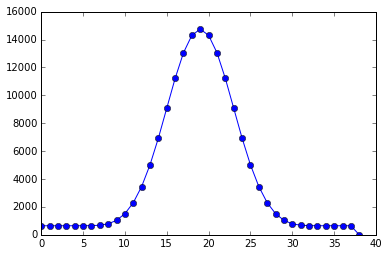

In [124]:
# Check what the instrument memory holds
# For some reason, it can only pull 38 values.
wave = []
for i in range(1,numPoints):
    #sleep(0.2)
    wave.append( handle.ask(":DATA:VALUE? VOLATILE,{}".format(i)) )
    
print(wave)
plt.plot(wave,"o-")

## TODO: the VfromI function gives voltage, we need to scale this before uploading to Arb.

In [ ]:
handle.close()